In [1]:
import sys
import sklearn
import numpy as np
import os

In [2]:
# mnist데이터 불러오기

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

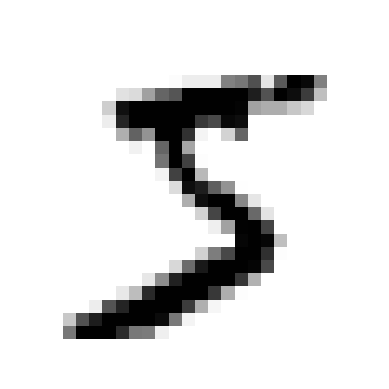

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [7]:
y[0]

5

mnist의 가장 첫번째 이미지는 위와 같고 이의 레이블은 5임을 알 수 있다

In [8]:
# 알고리즘 학습을 위해 숫자로 타입 변경

y = y.astype(np.uint8)

In [14]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [15]:
# mnist의 숫자들을 사진으로 붙여서 출력

import math

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = math.ceil(len(instances) / images_per_row)

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape(n_rows, images_per_row, size, size)
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
    
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

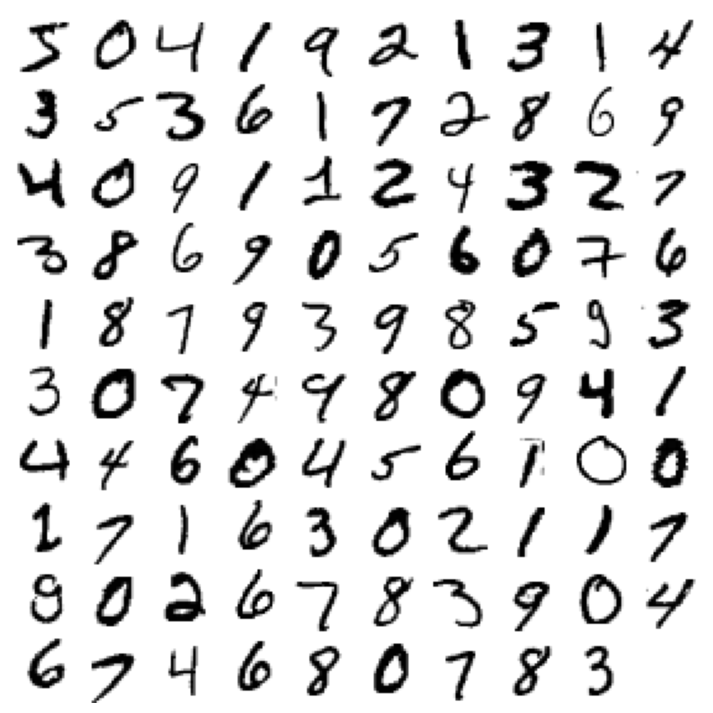

In [19]:
plt.figure(figsize=(9,9))
example_images = X[:99]
plot_digits(example_images, images_per_row=10)
plt.show()

In [20]:
# 훈련셋과 테스트셋 분리

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [21]:
# 5인지 아닌지 이진 분류기 만들기

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [22]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [23]:
# 선형 분류로 교차 검증을 통한 이진 분류기 측정

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

StratifiedKFold는 각 클래스별로 비율이 유지되도록 폴드를 나눠서 학습하는 것이다.

각 클래스별로 비율이 유지되야 하는 이유는 데이터의 수가 적을 경우 샘플링 편향이 생길 수 있기 때문이다.

예를 들면 만약에 우연한 계기로 데이터를 나누는데, 한쪽에는 특정 클래스의 데이터가 많이 분포하여 예측 모델이 한쪽으로 치우치게 나올 수 있기 때문이다.

In [24]:
# StratifiedKFold통해 균일하게 폴드 나누기

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [25]:
# 모두다 5가 아니라고 하는 모델 정확도 측정

from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

mnist의 경우 숫자가 0부터 9까지 10종류가 골고루 있기 때문에 전부 아니라고 답을 해도 정확도가 90프로가 나오게 된다.

따라서 이 데이터셋은 정확도를 분류기의 성능지표로 설정하면 안된다는 것을 보여준다.

In [26]:
# 오차 행렬을 이용한 분류기 평가

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [27]:
# 오차행렬

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [28]:
# 정밀도(precision_score), 재현율(recall_score) 구하기

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [29]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [30]:
# F1 점수 구하기

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [32]:
# 정밀도 재현율 트레이드오프 시각화

from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

3370.0194991439557


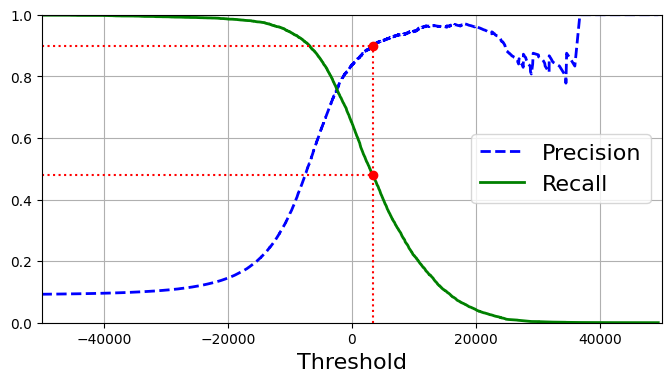

In [49]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)  
    plt.grid(True)    
    plt.axis([-50000, 50000, 0, 1])   

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

plt.figure(figsize=(8, 4))                                                         
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:") 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")         
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                              
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

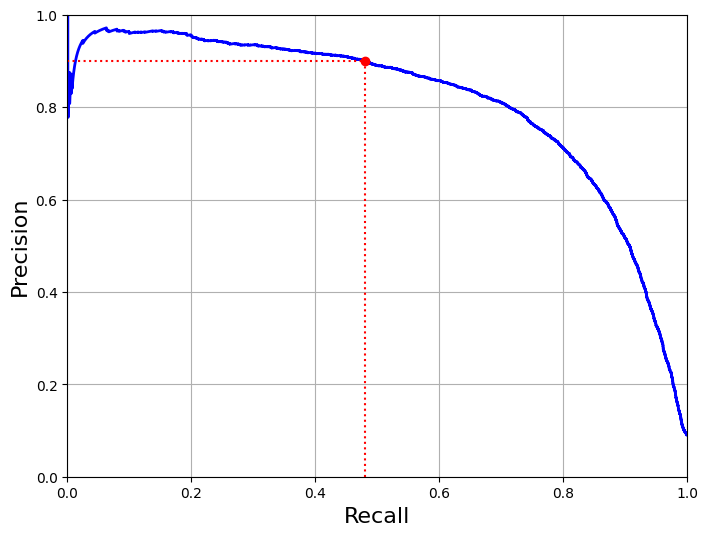

In [40]:
# 재현율에 대한 정밀도 곡선

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [46]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [47]:
# 정밀도

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [48]:
# 정밀도가 90%일 때 재현율
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [49]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


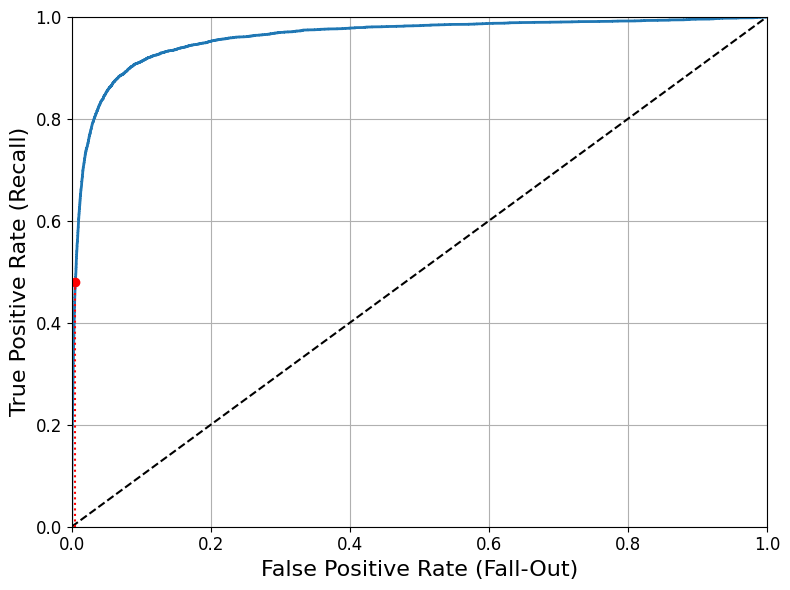

In [50]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

In [51]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [52]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [53]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

그림 저장: roc_curve_comparison_plot


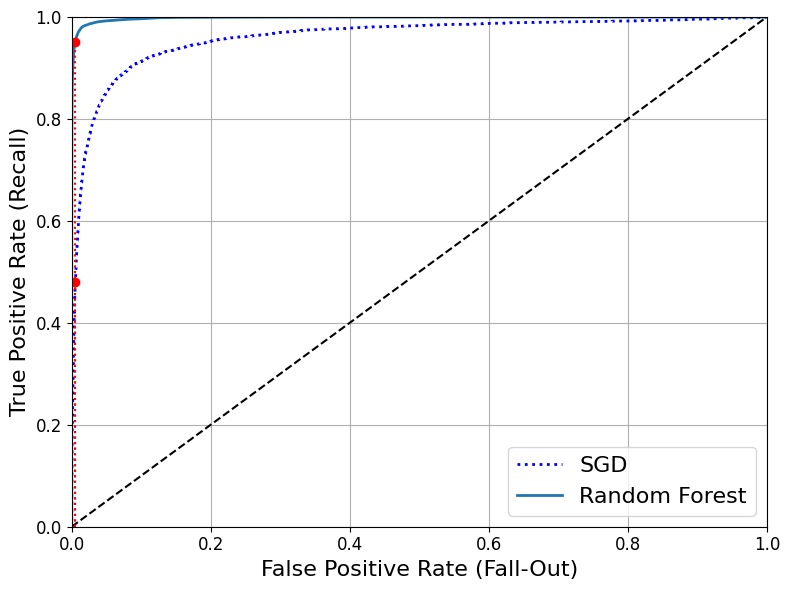

In [54]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [55]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [56]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [57]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

In [58]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [59]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [60]:
np.argmax(some_digit_scores)

5

In [61]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [62]:
svm_clf.classes_[5]

5

In [63]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [64]:
len(ovr_clf.estimators_)

10

In [65]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [66]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [67]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [69]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

In [70]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

그림 저장: confusion_matrix_plot


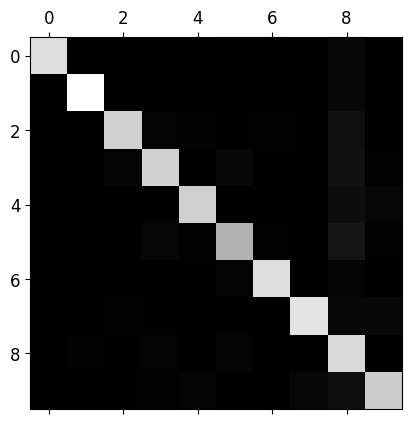

In [71]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [72]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

그림 저장: confusion_matrix_errors_plot


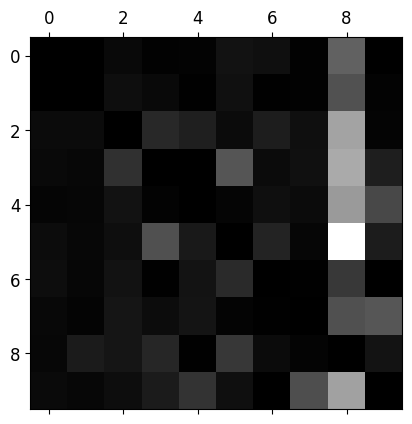

In [73]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

그림 저장: error_analysis_digits_plot


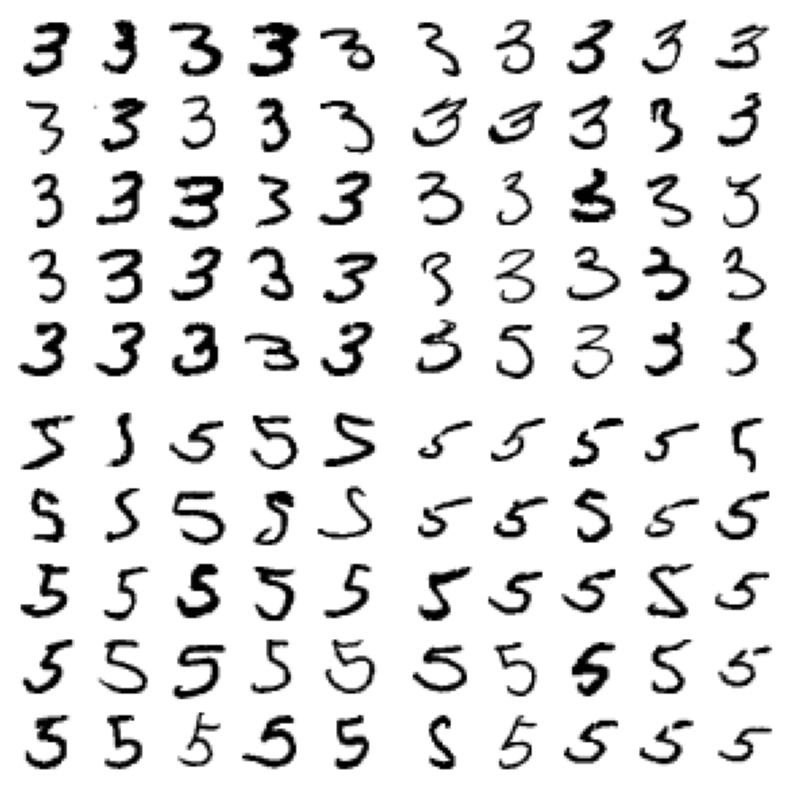

In [74]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [75]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [76]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [77]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [78]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

그림 저장: noisy_digit_example_plot


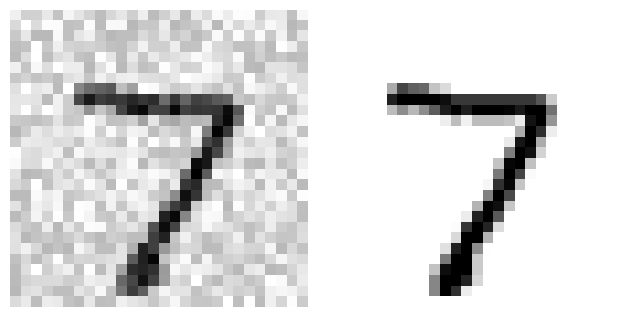

In [79]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

그림 저장: cleaned_digit_example_plot


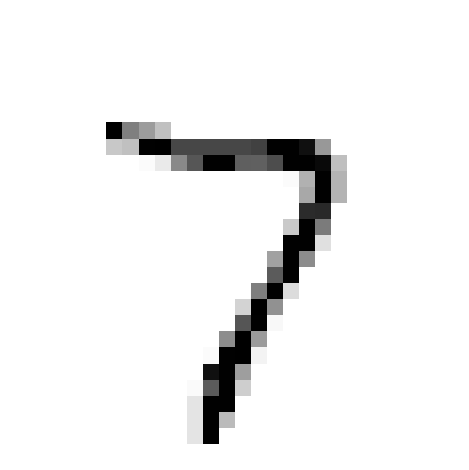

In [80]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

In [81]:
from sklearn.dummy import DummyClassifier
# 0.24버전부터 strategy의 기본값이 'stratified'에서 'prior'로 바뀌므로 명시적으로 지정합니다.
dmy_clf = DummyClassifier(strategy='prior')
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

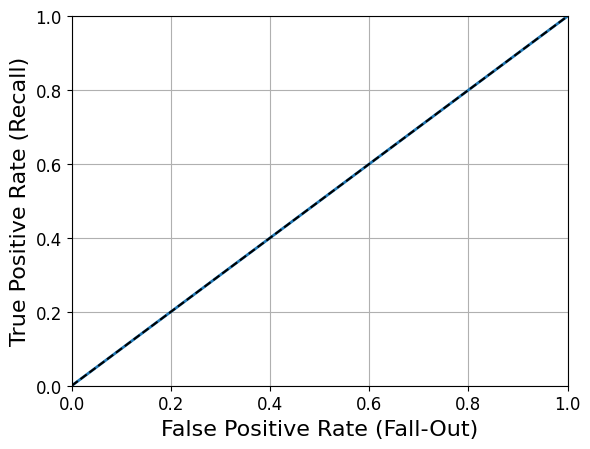

In [82]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

In [83]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [84]:
y_knn_pred = knn_clf.predict(X_test)

In [85]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

C:\Users\leedo\AppData\Local\Temp\ipykernel_17516\3518175631.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


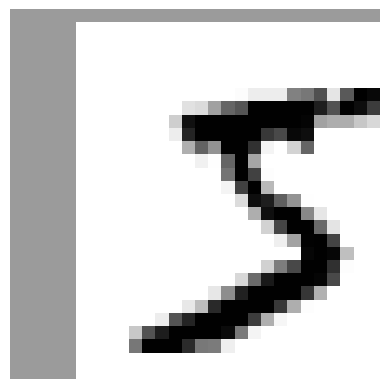

In [86]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [87]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [88]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [89]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [90]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [91]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

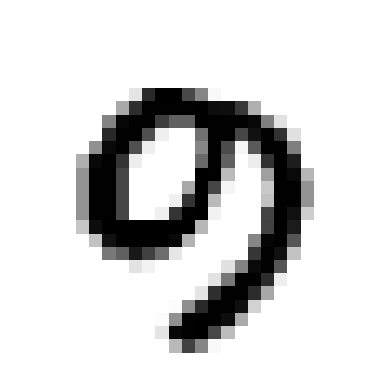

In [92]:
plot_digit(ambiguous_digit)